# Select and Filter Ratings

In this jupyter notebook I will perform the cleaning, selection and filtering of the ratings users gave to some movies.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

Read the MovieLens ratings dataset

In [25]:
ratings = pd.read_parquet('../Data/Raw/ratings.parquet')
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [26]:
print(f'The dataset has {ratings.shape[0]:,} ratings from {len(ratings['userId'].unique()):,} users')

The dataset has 32,000,204 ratings from 200,948 users


In [27]:
# Check if there are decimal values
decimals = ratings[ratings['rating'] % 1 != 0].shape[0]
print(f'There are {decimals:,} ratigns with .5 values')

There are 10,005,686 ratigns with .5 values


## Plot the Distribution of the ratings (1-5)

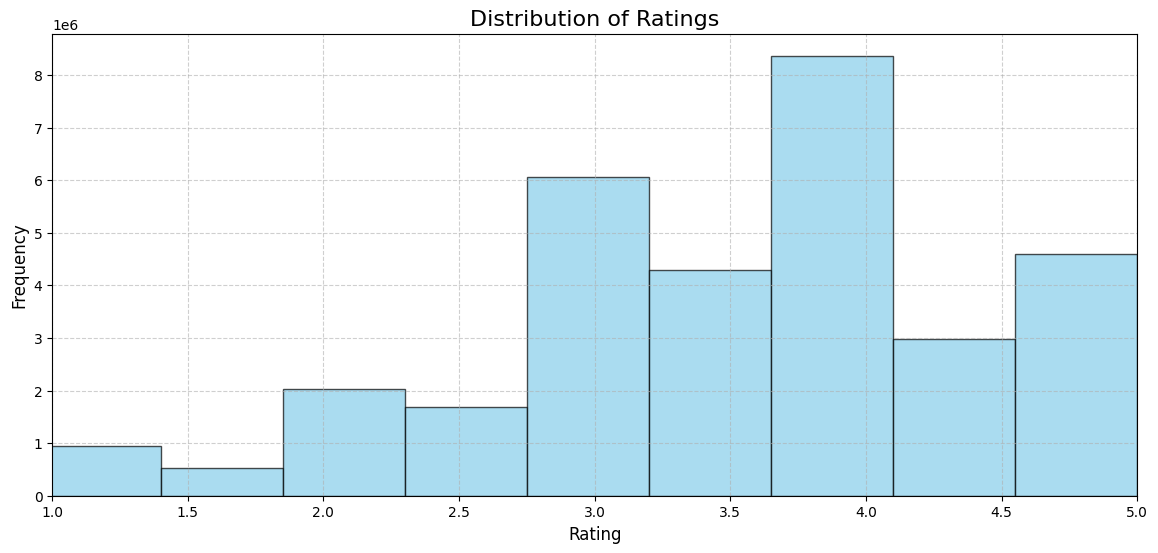

In [28]:
plt.figure(figsize=(14, 6))
#Since the ratings range from 1 to 5, with the possibility of half-point increments, we will use 10 bins
plt.hist(ratings['rating'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(1, 5)
plt.show()

- The most commonly used rating is 4.0 with more than 8 millions, followed by 3.0 with 6 millions
- The least used rating is 1.5
- We can see there's a bias toward ratings of 3 or higher, i.e. most votes are 3 or above
- Users tend to give whole number ratings, meaning they don't use half-points

### Plot the year where users gave the ratings

In [29]:
# Convert the timestamp format
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Extract the year
ratings['year'] = ratings['timestamp'].dt.year
ratings.head()

,userId,movieId,rating,timestamp,year
0,1,17,4.0,1999-12-03 19:24:37,1999
1,1,25,1.0,1999-12-03 19:43:48,1999
2,1,29,2.0,1999-11-22 00:36:16,1999
3,1,30,5.0,1999-12-03 19:24:37,1999
4,1,32,5.0,1999-11-22 00:00:58,1999


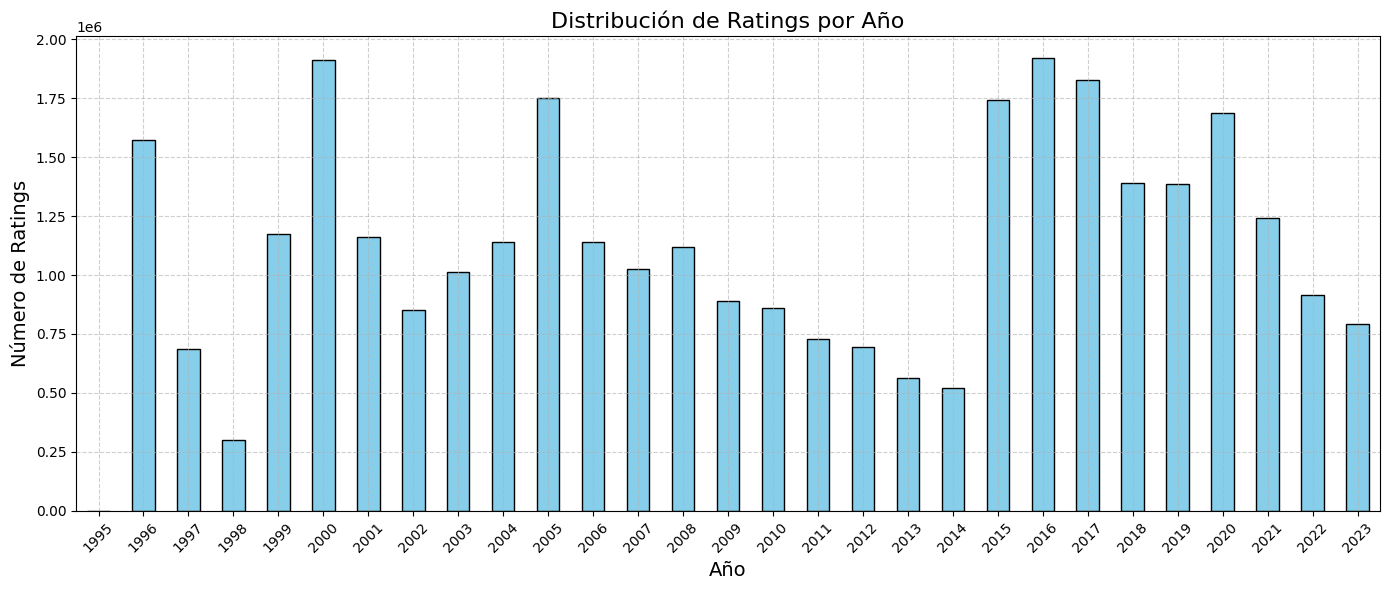

In [30]:
# Plot the distribution frequency of ratigns per year
ratings_by_year = ratings.groupby('year').size()
plt.figure(figsize=(14, 6))
ratings_by_year.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribución de Ratings por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Ratings', fontsize=14)

# Improve ticks
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Show it
plt.tight_layout()
plt.show()

- The plot is a bar chart showing the number of ratings received per year from 1995 to 2023.
- The years 2000, 2005, 2015, and 2016 stand out with very high numbers of ratings (around or above 1.75 million).
- There's a noticeable drop in ratings between 2008 and 2014, hitting a low point around 2014.
- After 2014, there's a sharp increase in ratings, peaking in 2016.
- There's a general pattern of fluctuations, suggesting varying popularity or availability of movies across years.

## Count Ratings per User

Since the dataset has a lot of ratings, we have to filter some users, so we ensure data quality for our reccomender system and avoid data sparsity

In [31]:
# Count the number of ratings per user
ratings_count = ratings.groupby('userId')['rating'].count()
ratings_count.head()

userId
1    141
2     52
3    147
4     27
5     33
Name: rating, dtype: int64

In [32]:
print(f'We have {ratings_count.shape[0]} users')

We have 200948 users


In [33]:
ratings_count.describe()

count    200948.000000
mean        159.246193
std         282.025462
min          20.000000
25%          36.000000
50%          73.000000
75%         167.000000
max       33332.000000
Name: rating, dtype: float64

- On average, a user rated approximately 159 movies.
- There's high variability in user activity, as shown by a standard deviation of ~282 ratings.
- The minimum number of ratings per user is 20, which could indicate a filtering threshold.
- 25% of users rated 36 or fewer movies.
- 50% (median) rated 73 movies or less.
- 75% rated up to 167 movies.
- The most active user gave a whopping 33,332 ratings, which is over 200× more than the median.

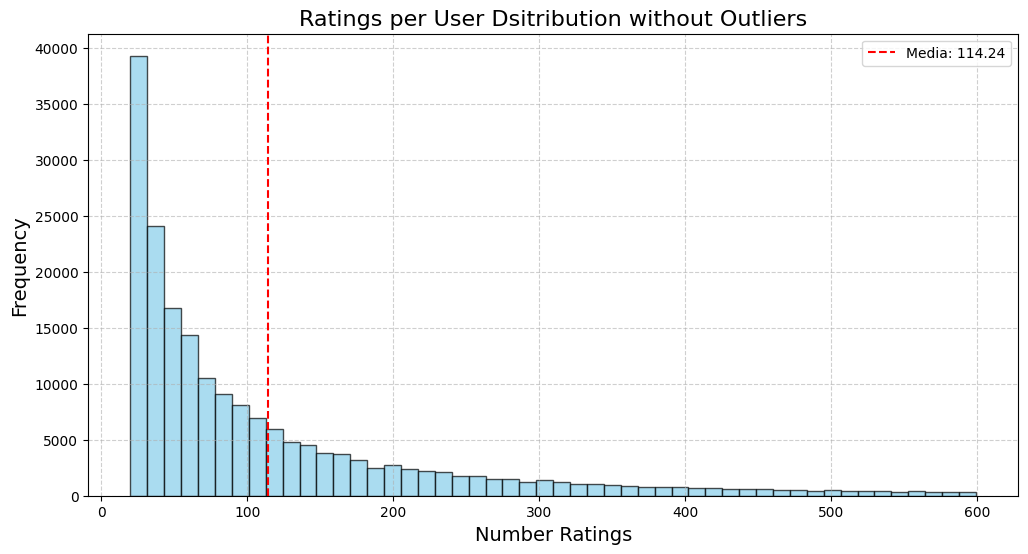

In [34]:
# Filter users with less than 600 ratings to improve the plot
ratings_filtered = ratings_count[ratings_count < 600]

# Create the plot
plt.figure(figsize=(12, 6))
plt.hist(ratings_filtered, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Plot the mean
plt.axvline(ratings_filtered.mean(), color='red', linestyle='--', label=f'Media: {ratings_filtered.mean():.2f}')

# Add labels and title
plt.title('Ratings per User Dsitribution without Outliers', fontsize=16)
plt.xlabel('Number Ratings', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Filter Users

This skewed distribution suggests the presence of power users who may disproportionately influence model training or distort average statistics. To ensure good data quality for the movie recommender system, it's important to filter out users who might not provide enough useful or diverse information.

We will filter users by:

- Select the ratings of the movies that are in the final dataset
- Filtering out users who have rated movies from fewer than 5 different genres, as low genre diversity may indicate limited viewing preferences.
- Removing users who exclusively use 2 same scores or less, i.e. a user that rate all the mavoes with 4 and 5.
- Setting a minimum threshold of 50 ratings per user and a maximum threshold of 250, to focus on users with meaningful but not extreme activity.

#### Get the final movie ids

In [35]:
movies_ids = pd.read_csv('../Data/Processed/movies_ids.csv')
movies_ids.head()

,movieId,id
0,16,524
1,11,9087
2,7,11860
3,1,862
4,12,12110


#### Select only the ratings of the movies that are in our dataset

In [36]:
selected_ratings = ratings[ratings['movieId'].isin(movies_ids['movieId'])]
selected_ratings.head()

,userId,movieId,rating,timestamp,year
0,1,17,4.0,1999-12-03 19:24:37,1999
1,1,25,1.0,1999-12-03 19:43:48,1999
2,1,29,2.0,1999-11-22 00:36:16,1999
4,1,32,5.0,1999-11-22 00:00:58,1999
5,1,34,2.0,1999-11-21 23:54:51,1999


In [37]:
print(f'After selecting the ratings that include the selected movies we have {selected_ratings.shape[0]:,} ratings')

After selecting the ratings that include the selected movies we have 23,612,640 ratings


#### Select users that rate more than 5 different genres

In [38]:
# Read the movies dataset and extract the genres
movies = pd.read_csv('../Data/Processed/movies_final.csv')
movies['genres'] = movies['genres'].map(ast.literal_eval).map(lambda x: [g['name'] for g in x])

# Keep only relevant columns and explode
movie_genres = movies[['movieId', 'genres']].explode('genres')

# Merge directly with selected_ratings
merged = selected_ratings.merge(movie_genres, on='movieId', how='inner')

# Count unique genres per user
genre_counts = merged.groupby('userId')['genres'].nunique()

# Filter users with more than 5 unique genres
qualified_users = genre_counts[genre_counts > 5].index

# Step 6: Filter the merged DataFrame if needed
filtered_ratings = selected_ratings[selected_ratings['userId'].isin(qualified_users)]

In [39]:
print(f'After selecting the ratings that include 5 or more genres we have {filtered_ratings.shape[0]:,} ratings')

After selecting the ratings that include 5 or more genres we have 23,611,903 ratings


As we can see, all the selected users had already rated 5 or more different genres

#### Remove users who exclusively use 2 same ratings

In [40]:
# Count unique scores per user
score_count = selected_ratings.groupby('userId')['rating'].nunique()

# Select the users
valid_users = score_count[score_count > 2].index
selected_ratings = selected_ratings[selected_ratings['userId'].isin(valid_users)]

print(f'After selecting the users that use more than 2 different scores we have {selected_ratings.shape[0]:,} ratings')


After selecting the users that use more than 2 different scores we have 23,546,456 ratings


It didn’t change much; we just removed around 70k ratings.

#### Select the users that rated more than 49 movies and less than 249

In [41]:
# Count the number of ratings each user gave
ratings_count = selected_ratings.groupby('userId')['rating'].count()
ratings_count.head()

userId
1    101
2     23
3     88
4     20
5     20
Name: rating, dtype: int64

In [46]:
# Select the users as mentioned before
ratings_count = ratings_count[(ratings_count > 49) & (ratings_count < 249)]
aux = selected_ratings[selected_ratings['userId'].isin(ratings_count.index)]
aux = aux[['userId', 'movieId', 'rating']]

print(f'After selecting the users that rated more than 49 movies and less than 249, we have {aux.shape[0]:,} ratings from {len(aux['userId'].unique())} users')

After selecting the users that rated more than 49 movies and less than 249, we have 9,481,652 ratings from 85100 users


In [47]:
aux.head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
4,1,32,5.0
5,1,34,2.0


In [51]:
ratings_count = aux.groupby('userId')['rating'].count()
ratings_count.describe()

count    85100.000000
mean       111.417767
std         52.243904
min         50.000000
25%         68.000000
50%         96.000000
75%        145.000000
max        248.000000
Name: rating, dtype: float64

After all the ratings we are left with almost 9,500,000 ratings from 85,100 users. Now in average every user rated 111 movies, the 50% rated 96 movies or less, the minimun number of ratings is 50 and the maximum 248.

In [48]:
# Save the final ratings
aux.to_parquet('../Data/Processed/ratings_final.parquet', index=False)